In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
SEQUENCE_LENGTH = 16 # Define SEQUENCE_LENGTH here

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

def predict_single_video_with_visuals(
    path,
    frames_to_use=SEQUENCE_LENGTH,
    num_preview_frames=4
):
    """
    Predict REAL/FAKE for a video and show some frames with a nice visual summary.
    """
    model.eval()
    frames = []
    raw_preview_frames = []

    cap = cv2.VideoCapture(path)

    if not cap.isOpened():
        print("❌ Could not open video:", path)
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print("⚠️ Video has 0 frames:", path)
        cap.release()
        return

    # Choose a few frame indices to preview (evenly spaced)
    preview_idxs = np.linspace(0, max(total_frames - 1, 0),
                               num_preview_frames, dtype=int).tolist()

    idx = 0
    try:
        while len(frames) < frames_to_use:
            ok, frame = cap.read()
            if not ok:
                break

            # Save raw RGB frame for visuals
            if idx in preview_idxs:
                raw_preview_frames.append(cv2.cvtColor(frame.copy(),
                                                       cv2.COLOR_BGR2RGB))

            # Convert & transform for model
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            t = test_transforms(frame_rgb)
            frames.append(t)

            idx += 1
    finally:
        cap.release()

    if len(frames) == 0:
        print("⚠️ No frames in video after reading!")
        return

    # Pad with last frame if video is short
    if len(frames) < frames_to_use:
        last = frames[-1]
        while len(frames) < frames_to_use:
            frames.append(last.clone())

    # (T,3,112,112) -> (1,T,3,112,112)
    x = torch.stack(frames)[:frames_to_use]
    x = x.unsqueeze(0).to(device)

    # 🔮 Run model
    with torch.no_grad():
        out = model(x)
        probs = softmax(out, dim=1)[0].cpu().numpy()

    fake_p = probs[0] * 100
    real_p = probs[1] * 100
    label = "REAL" if real_p >= fake_p else "FAKE"

    emoji = "🟢" if label == "REAL" else "🔴"
    big_text = f"{emoji} PREDICTION: {label}"
    detail_text = f"REAL: {real_p:.2f}%   |   FAKE: {fake_p:.2f}%"

    # ==============================
    # 🖼️ Show preview frames
    # ==============================
    if len(raw_preview_frames) > 0:
        cols = len(raw_preview_frames)
        fig, axes = plt.subplots(1, cols, figsize=(4*cols, 4))

        if cols == 1:
            axes = [axes]

        for i, (ax, img) in enumerate(zip(axes, raw_preview_frames)):
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"Frame {i+1}")

        plt.suptitle(big_text + "\n" + detail_text, fontsize=14, y=1.05)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No preview frames captured to display.")

    # ==============================
    # 📝 Print nice summary
    # ==============================
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print(big_text)
    print(detail_text)
    print("Video:", path)
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

    return label, real_p, fake_p

In [ ]:
# CELL: Load your Deepfake-LSTM model back into memory ⚙️

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

SEQUENCE_LENGTH = 10
IM_SIZE = 112
HIDDEN_SIZE = 256

# Define the test_transforms here
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 🔽🔽🔽 IMPORTANT: PASTE YOUR REAL MODEL CLASS HERE (same as training!)
class DeepfakeLSTMModel(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, num_layers=1, num_classes=2):
        super().__init__()

        self.backbone = resnext50_32x4d(
            weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1
        )
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        feats = self.backbone(x)
        feats = feats.view(B, T, -1)
        lstm_out, _ = self.lstm(feats)
        last = lstm_out[:, -1, :]
        return self.fc(last)

# 🔽 Create model
model = DeepfakeLSTMModel().to(device)

# 🔽 Load weights
weights_path = "/content/drive/MyDrive/deepfake_lstm_trained.pth"
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

print("✅ Model loaded successfully!")

Using device: cpu
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


100%|██████████| 95.8M/95.8M [00:00<00:00, 121MB/s]


✅ Model loaded successfully!


In [ ]:
# CELL: Pretty prediction with visuals 🎬📊

import os
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

def predict_single_video_with_visuals(path, frames_to_use=SEQUENCE_LENGTH, num_preview_frames=8):
    """
    Predict REAL/FAKE for a video and show:
      - some sampled frames
      - bar chart of final probabilities
      - heatmap over time (how probs change as more frames are seen)
    """
    print("🎬 Analyzing video:", path)

    # Try to show metadata label if available (won't crash if not)
    try:
        meta_label = labels_map.get(os.path.basename(path))
        print(f"🧾 Label from metadata: {meta_label}")
    except Exception:
        print("ℹ️ labels_map not available in this session (skipping metadata label).")

    model.eval()
    frames = []
    raw_frames = []   # for showing original images

    cap = cv2.VideoCapture(path)
    try:
        while len(frames) < frames_to_use:
            ok, frame = cap.read()
            if not ok:
                break
            raw_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            raw_frames.append(raw_rgb)              # save raw frame for display
            t_frame = test_transforms(raw_rgb)      # apply your test transforms
            frames.append(t_frame)
    finally:
        cap.release()

    if len(frames) == 0:
        print("⚠️ No frames in video!")
        return

    # Pad frames if needed
    if len(frames) < frames_to_use:
        last = frames[-1]
        while len(frames) < frames_to_use:
            frames.append(last.clone())

    # ---- 1️⃣ Final prediction using all frames ----
    x = torch.stack(frames)[:frames_to_use]        # (T,3,112,112)
    x = x.unsqueeze(0).to(device)                  # (1,T,3,112,112)

    with torch.no_grad():
        out = model(x)
        probs = softmax(out, dim=1)[0].cpu().numpy()

    fake_p = float(probs[0]) * 100
    real_p = float(probs[1]) * 100
    label = "REAL ✅" if real_p >= fake_p else "FAKE ⚠️"

    print(f"\n📌 FINAL PREDICTION")
    print(f"   REAL: {real_p:.2f}%   FAKE: {fake_p:.2f}%  -> {label}")

    # ---- 2️⃣ Probabilities over time (for heatmap/line) ----
    real_over_time = []
    fake_over_time = []

    T_effective = min(frames_to_use, len(raw_frames))

    with torch.no_grad():
        for t in range(1, T_effective + 1):
            # use first t frames, pad to frames_to_use
            cur_frames = frames[:t]
            if len(cur_frames) < frames_to_use:
                last = cur_frames[-1]
                while len(cur_frames) < frames_to_use:
                    cur_frames.append(last.clone())

            x_t = torch.stack(cur_frames)[:frames_to_use].unsqueeze(0).to(device)
            out_t = model(x_t)
            p_t = softmax(out_t, dim=1)[0].cpu().numpy()
            fake_over_time.append(p_t[0])
            real_over_time.append(p_t[1])

    real_over_time = np.array(real_over_time)
    fake_over_time = np.array(fake_over_time)

    # ---- 3️⃣ Plot preview frames ----
    if len(raw_frames) > 0:
        num_preview_frames = min(num_preview_frames, len(raw_frames))
        idxs = np.linspace(0, len(raw_frames) - 1, num_preview_frames, dtype=int)

        plt.figure(figsize=(3 * num_preview_frames, 3))
        for i, idx in enumerate(idxs):
            ax = plt.subplot(1, num_preview_frames, i + 1)
            ax.imshow(raw_frames[idx])
            ax.set_title(f"F{idx}", fontsize=10)
            ax.axis("off")
        plt.suptitle("🎞️ Sample frames from video", fontsize=14)
        plt.tight_layout()
        plt.show()

    # ---- 4️⃣ Bar chart for final probs ----
    plt.figure(figsize=(4, 4))
    classes = ["FAKE", "REAL"]
    values = [fake_p, real_p]
    plt.bar(classes, values)
    plt.ylim(0, 100)
    plt.ylabel("Probability (%)")
    plt.title("📊 Final prediction confidence")
    for i, v in enumerate(values):
        plt.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=10)
    plt.show()

    # ---- 5️⃣ Heatmap over time ----
    prob_matrix = np.vstack([real_over_time, fake_over_time])  # shape (2, T)
    plt.figure(figsize=(max(6, T_effective // 2), 3))
    plt.imshow(prob_matrix, aspect="auto", vmin=0, vmax=1)
    plt.yticks([0, 1], ["REAL", "FAKE"])
    plt.xlabel("Frame index (time)")
    plt.title("🔥 Probability over time (per frame chunk)")
    cbar = plt.colorbar()
    cbar.set_label("Probability")
    plt.show()

    return label, real_p, fake_p


🎬 Analyzing video: /content/drive/MyDrive/FF_REAL_Face_only_data/id0_id3_0001.mp4
ℹ️ labels_map not available in this session (skipping metadata label).

📌 FINAL PREDICTION
   REAL: 0.46%   FAKE: 99.54%  -> FAKE ⚠️


/tmp/ipython-input-267017791.py:102: UserWarning: Glyph 127902 (\N{FILM FRAMES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127902 (\N{FILM FRAMES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


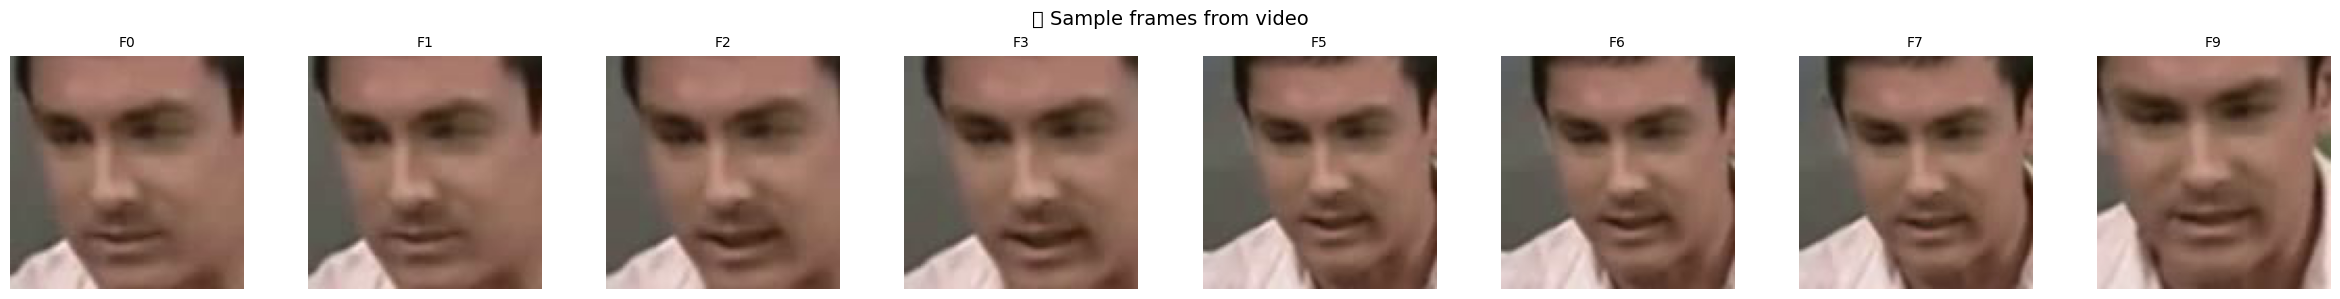

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


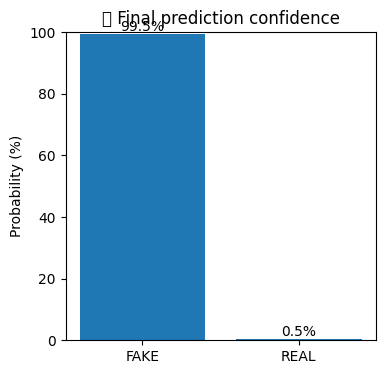

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


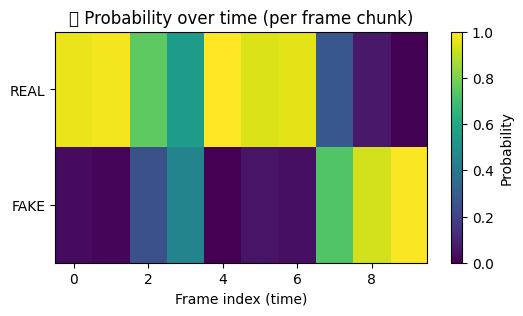

('FAKE ⚠️', 0.4613943863660097, 99.53860640525818)

In [ ]:
# CELL: Run prediction on one test video 🎬

test_video = "/content/drive/MyDrive/FF_REAL_Face_only_data/id0_id3_0001.mp4"
predict_single_video_with_visuals(test_video)
